In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import json
import mplcursors
import base64
from scipy.signal import savgol_filter

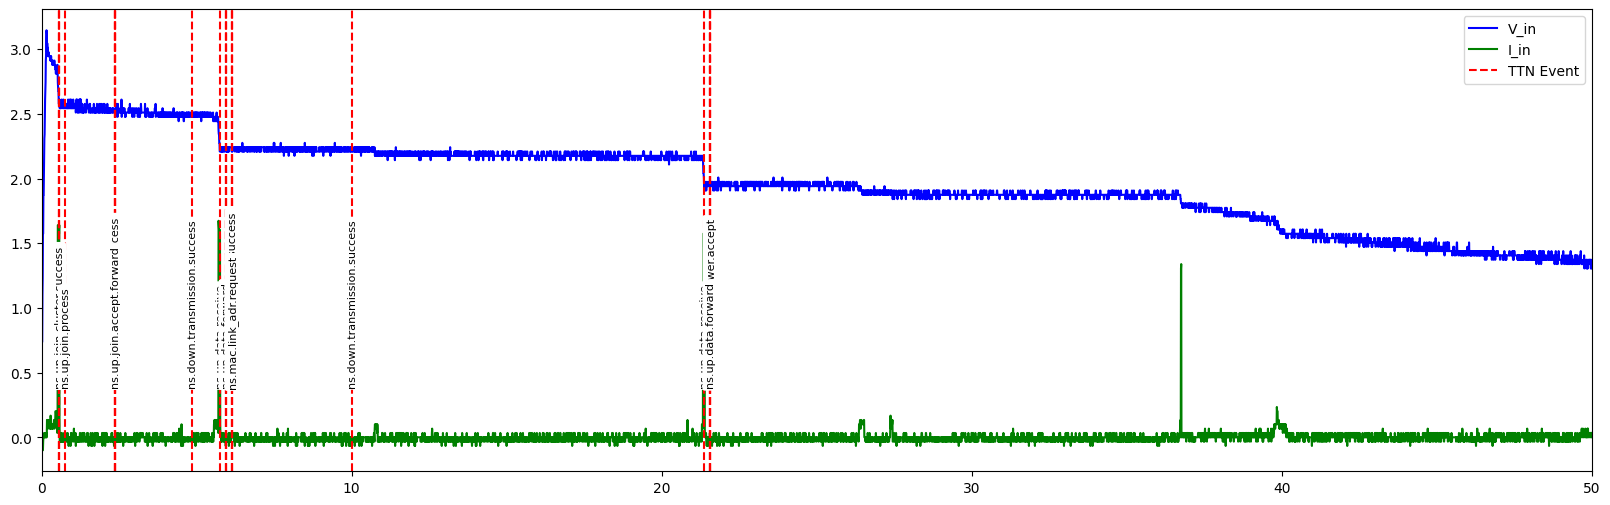

In [6]:
#################################################
#                                               #
#                   TTN Overlay                 #
#                                               #
#################################################

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import json

# Note: time logs in TTN have an offset from the scope data which isn't time-stamped (only relative to starting point)

file = '220ms_40mF1'
lower_limit = 0
upper_limit = 50
offset = 0.55

scope_data = pd.read_csv('./Scope/{}.csv'.format(file))

plt.figure(figsize=(20, 6))
plt.plot(scope_data['second'], scope_data['V_in'], color='b', label="V_in")
plt.plot(scope_data['second'], scope_data['I_in'], color='g', label="I_in")

ttn_json = open('./TTN/{}.json'.format(file))
ttn_logs = json.load(ttn_json)
ttn_logs.reverse()
if ttn_logs[0]['name'] == 'synthetic.status.cleared':
    ttn_logs = ttn_logs[1:]
ttn_json.close()

events = []
timestamps = []
reference_time = datetime.fromisoformat(ttn_logs[0]['time'])
for log in ttn_logs:
    events.append(log['name'])
    time_elapsed = (datetime.fromisoformat(log['time']) - reference_time).total_seconds()
    timestamps.append(time_elapsed)

for timestamp, event in zip(timestamps, events):
    time = timestamp+offset
    line = plt.axvline(x=time, color='r', linestyle='--')
    plt.annotate(event, xy=(time, 0), xytext=(time, 0.4), color='black', ha='center', fontsize=8,
        rotation=90, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))
plt.plot([], [], color='r', linestyle='--', label='TTN Event')

plt.xlim(lower_limit, upper_limit)
plt.legend(loc='upper right')
plt.show()

In [7]:
#################################################
#                                               #
#           Determining Window Bounds           #
#                                               #
#################################################

import pandas as pd
import matplotlib.pyplot as plt

def get_bounds(file):

    extend = 0      # Expand windows found this many in either direction to contain events better
    scope_data = pd.read_csv('./Scope/{}.csv'.format(file))

    transmission_windows = []
    rx_windows = []

    def check_valid(element, list, skip=None):   # Returns False if no problems
        if element[1] - element[0] < 3:    # Don't allow overly small windows
            return True
        if skip != None:    # Skip the overlay check
            return True
        overlap = False     # Don't allow RX and transmission windows to coincide
        element_start, element_end = element
        for window in list:
            window_start, window_end = window
            if not (element_end < window_start or element_start > window_end):
                overlap = True
                break
        return overlap

    # Get transmission windows

    start_index = None
    for index, val in enumerate(scope_data['I_in']):
        if val > 1.4:
            if start_index is None:
                start_index = index
        else:
            if start_index is not None:
                window = (start_index - extend, index - 1 + extend)
                if not check_valid(window, transmission_windows):
                    transmission_windows.append(window)
                start_index = None
    if start_index is not None:
        window = (start_index - extend, len(scope_data['I_in']) - 1)
        if not check_valid(window, transmission_windows):
            transmission_windows.append(window)
    transmission_windows = transmission_windows[1:]

    # Return empty lists if transmission never successfully occurred

    if len(transmission_windows) == 0:
        return [[], []]

    # Get RX windows

    start_index = None
    for index, val in enumerate(scope_data['I_in']):
        if index < transmission_windows[0][0] or index > transmission_windows[-1][1] + 900:  # Skip anything before the first transmission and more than ~15s after last transmission
            continue
        if val > 0.07 and val < 0.2:
            if start_index is None:
                start_index = index
        else:
            if start_index is not None and val < 0.03:
                window = (start_index - extend, index - 1 + extend)
                if not check_valid(window, transmission_windows):
                    rx_windows.append(window)
                start_index = None
    if start_index is not None:
        window = (start_index - extend, len(scope_data['I_in']) - 1)
        if not check_valid(window, transmission_windows):
            rx_windows.append(window)

    return [transmission_windows, rx_windows]

def plot_bounds(file, windows, limits=None):

    scope_data = pd.read_csv('./Scope/{}.csv'.format(file))

    plt.figure(figsize=(20, 3))
    plt.plot(scope_data['second'], scope_data['I_in'], color='g', label="I_in")
    plt.plot(scope_data['second'], scope_data['V_in'], color='b', label="V_in")

    transmission_windows, rx_windows = windows

    for window in transmission_windows:
        for index in window:
            timestamp = scope_data['second'].iloc[index]
            plt.axvline(x=timestamp, color='r', linestyle='--')
            plt.annotate(timestamp, xy=(timestamp, 0), xytext=(timestamp, 0.5), color='black', ha='center', fontsize=8,
                rotation=90, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

    for window in rx_windows:
        for index in window:
            timestamp = scope_data['second'].iloc[index]
            plt.axvline(x=timestamp, color='orange', linestyle='--')
            plt.annotate(timestamp, xy=(timestamp, 0), xytext=(timestamp, 0.5), color='black', ha='center', fontsize=8,
                rotation=90, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

    plt.plot([], [], color='r', linestyle='--', label='Transmission')
    plt.plot([], [], color='orange', linestyle='--', label='RX')
    plt.title('{} Windows of Operation'.format(file))
    plt.legend(loc='upper right')
    plt.xlabel('Time Elapsed (s)')
    plt.ylabel('Voltage Measurement (V)')

    if limits != None:
        plt.xlim(limits[0], limits[1])

    plt.show()

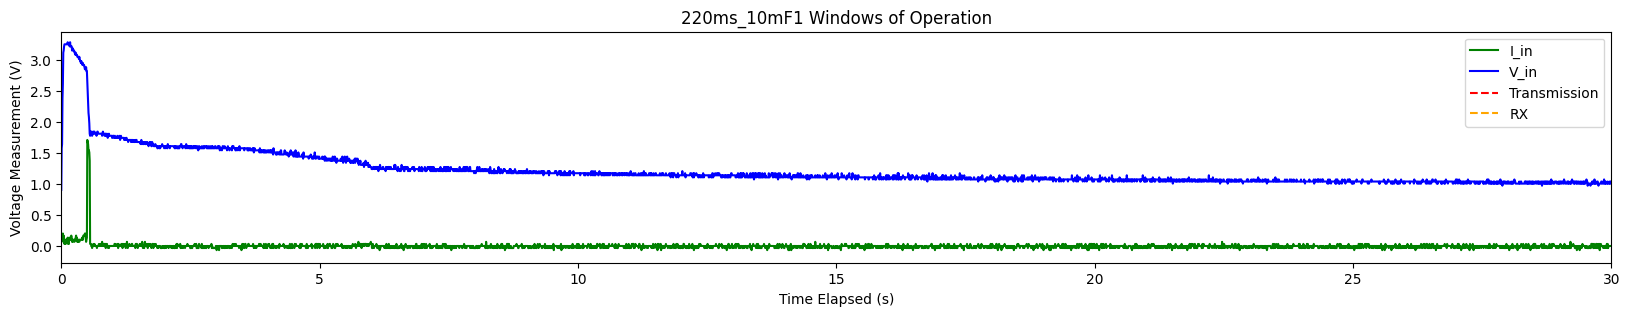

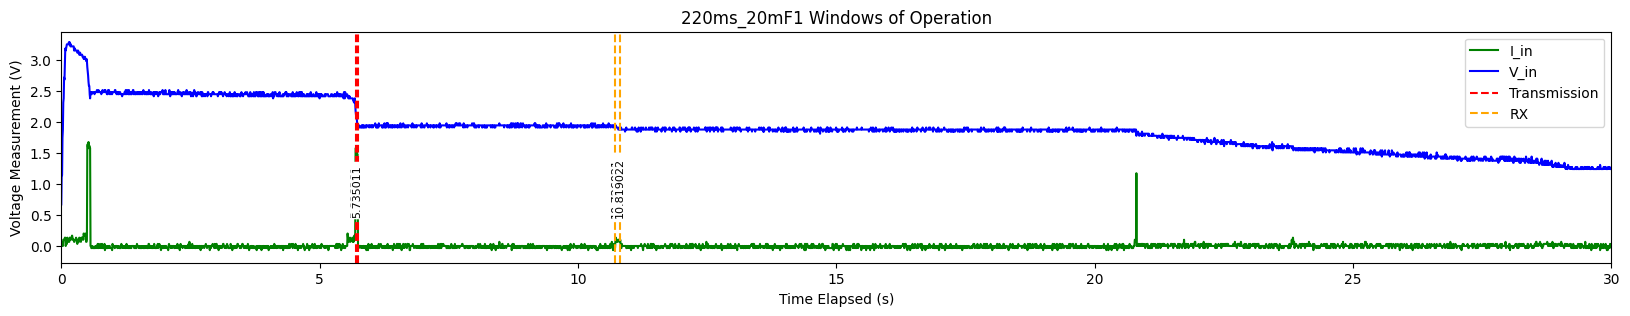

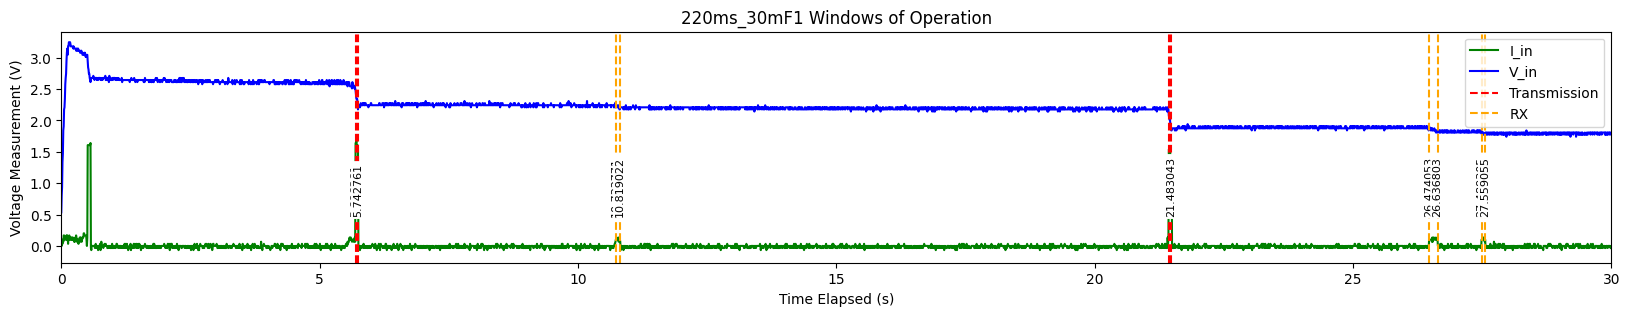

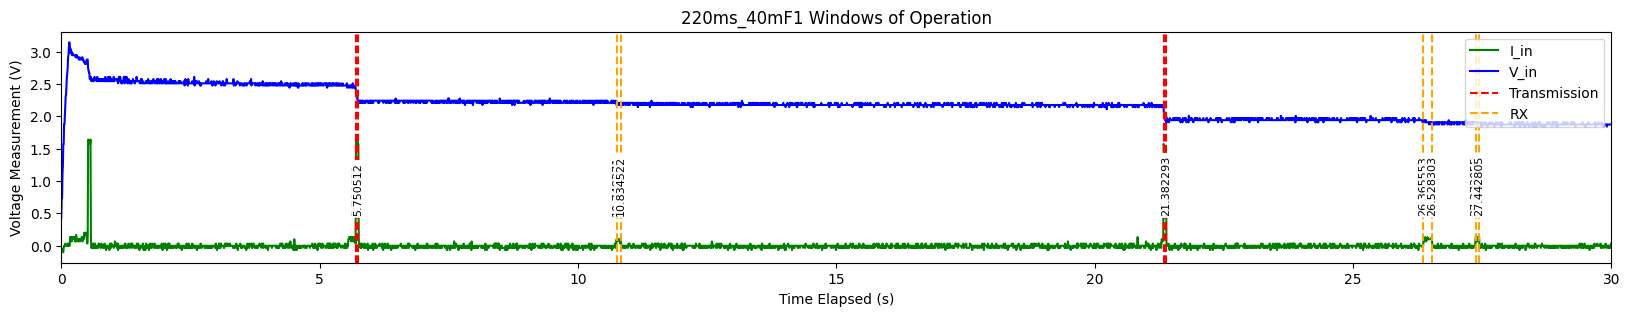

In [8]:
#################################################
#                                               #
#         Plot all C of one Pulse Length        #
#                                               #
#################################################

ms = 220

file = '{}ms_10mF1'.format(ms)
plot_bounds(file, get_bounds(file), limits=[0,30])
file = '{}ms_20mF1'.format(ms)
plot_bounds(file, get_bounds(file), limits=[0,30])
file = '{}ms_30mF1'.format(ms)
plot_bounds(file, get_bounds(file), limits=[0,30])
file = '{}ms_40mF1'.format(ms)
plot_bounds(file, get_bounds(file), limits=[0,30])

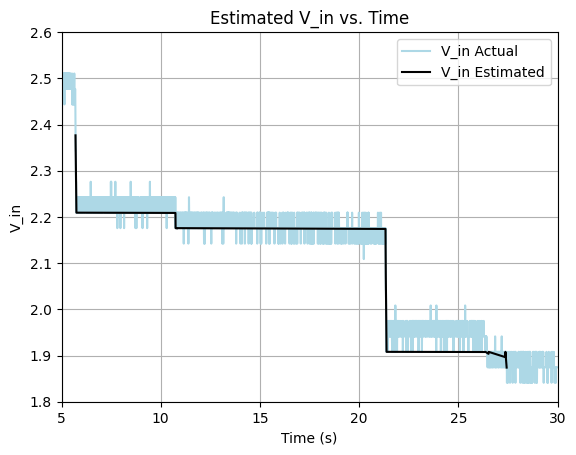

Optimal Req values:
Window 1: 15.061254203771993
Window 2: 491360.0
Window 3: 7680.0
Window 4: 327360.0
Window 5: 11.778473296496015
Window 6: 655280.0
Window 7: 1734.0268886861663
Window 8: 3486.132138633476
Window 9: 85.98007031913282
Root Mean Squared Error (RMSE): 0.028123621028252725


In [11]:
#################################################
#                                               #
#                   Optimizing                  #
#                                               #
#################################################

import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

ms = 220
C = 0.040
R_shunt = 1.071

file = '{}ms_{}mF1'.format(ms, int(C*1000))
transmission_windows, rx_windows = get_bounds(file)
scope_data = pd.read_csv('./Scope/{}.csv'.format(file))
V_in = scope_data['V_in']
seconds = scope_data['second']

window_indices = []
for start, end in transmission_windows + rx_windows:
    window_indices.extend([start, end])
window_indices.sort()

# Fit the model to the data between each pair of consecutive indices in window_indices
optimal_Req_values = []
for i in range(0, len(window_indices)-1):

    initial_voltage = V_in[window_indices[i]] # noise making initial voltage under/overshoot is an issue?
    # initial_voltage = V_in[window_indices[i]:window_indices[i]+5].mean()

    start, end = window_indices[i], window_indices[i + 1] - 1
    t = seconds[start:end+1].reset_index(drop=True) - seconds[start]
    V = V_in[start:end+1].reset_index(drop=True)

    def model(t, R):
        return initial_voltage * np.exp(-t / (R * C))
    
    initial_guess = 10.0 
    
    params, _ = curve_fit(model, t, V, p0=initial_guess, bounds=(0, np.inf))

    optimal_Req_values.append(params[0])

# optimal_Req_values = [0 if val < 0.0000001 else val for val in optimal_Req_values]

times = []
estimations = []
# estimations = [V_in[window_indices[0]-1]]

for i in range(0, len(window_indices)-1):

    initial_voltage = V_in[window_indices[i]]
    # initial_voltage = estimations[-1]
    # initial_voltage = V_in[window_indices[i]:window_indices[i]+5].mean()

    start, end = window_indices[i], window_indices[i + 1] - 1
    t = seconds[start:end+1] - seconds[start]
    V = V_in[start:end+1]

    def model(t, R):
        return initial_voltage * np.exp(-t / (R * C))
    
    estimations.extend(model(t, optimal_Req_values[i]))
    times.extend(t + seconds[start])
    
plt.plot(seconds, V_in, color='lightblue', label="V_in Actual")
plt.plot(times, estimations, color='black', label="V_in Estimated", zorder=2, linestyle='-')
plt.xlim(5, 30)
plt.ylim(1.8, 2.6)
plt.xlabel('Time (s)')
plt.ylabel('V_in')
plt.title('Estimated V_in vs. Time')
plt.legend()
plt.grid(True)
plt.show()

print("Optimal Req values:")
for i, Req in enumerate(optimal_Req_values):
    print(f"Window {i+1}: {Req}")

# Calculate the mean squared error
mse = mean_squared_error(V_in[window_indices[0]:window_indices[-1]], estimations)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse}")